# Train-test of single PINN poisson

In [35]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
from jax.nn import leaky_relu
import jax.numpy as np
import numpy as onp


In [45]:
from utils import data_path 
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
xpinn = XPINN(file, leaky_relu)

In [46]:
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def boundary_loss_factory(index: int, target: float | Array)-> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = xpinn.PINNs[index].v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss


In [47]:
def interior_loss_factory(index:int,rhs:float)-> LFunc:
    model = xpinn.PINNs[index].model
    hess = lambda params: hessian(lambda x : model(params,x))
    residual = lambda params, x : np.trace(hess(params)(x)[0]) - rhs
    v_residual = vmap(residual, (None, 0))
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points:dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params,pts) ** 2)
    
    return interior_loss

In [48]:
p0 = xpinn.PINNs[0]

p0.boundary_loss = boundary_loss_factory(0, 0)


p0.interior_loss = interior_loss_factory(0, 0.0)
p0.create_loss()

<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x0000023C9ED4C540>>

In [49]:
shapes = [[2, 20, 20, 20, 1], [2, 60, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=exponential_decay)

    pinn.init_params(shape, optimizer)

In [50]:
n_iter = 10000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 0.00010176275827689096
10.00% iter = 1000 of 10000: Total loss = 8.813377816180995e-17
20.00% iter = 2000 of 10000: Total loss = 8.798266880750876e-17
30.00% iter = 3000 of 10000: Total loss = 8.759506520735622e-17
40.00% iter = 4000 of 10000: Total loss = 8.665147050411492e-17
50.00% iter = 5000 of 10000: Total loss = 8.632384080709492e-17
60.00% iter = 6000 of 10000: Total loss = 8.575937937453364e-17
70.00% iter = 7000 of 10000: Total loss = 2.836810430659198e-12
80.00% iter = 8000 of 10000: Total loss = 6.358625380712299e-17
90.00% iter = 9000 of 10000: Total loss = 1.6374925308742615e-17
100.00% iter = 10000 of 10000: Total loss = 7.877059972989566e-15


Text(0.5, 1.0, 'Loss per Pinn over 10000 epochs')

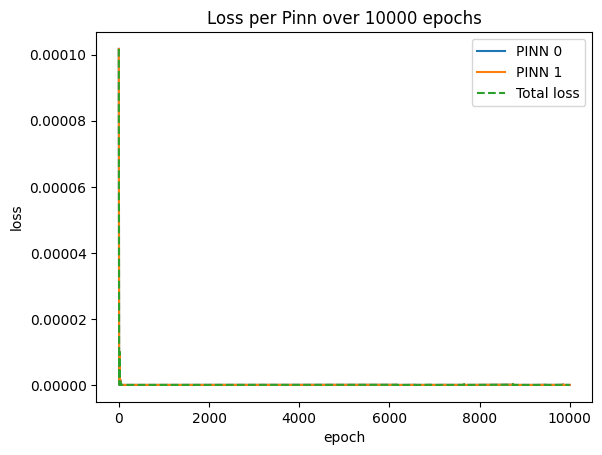

In [51]:
import matplotlib.pyplot as plt

a_losses = np.asarray(losses).T
t_0 = 0
t = np.arange(t_0, n_iter)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

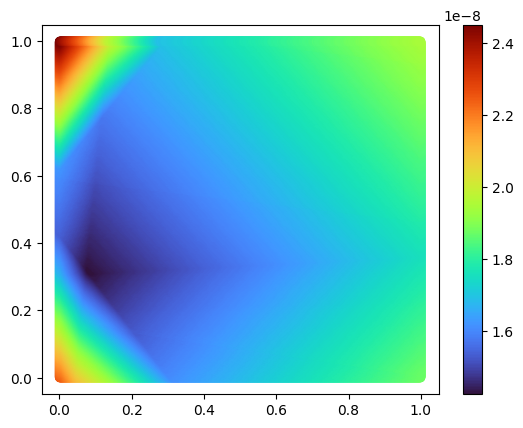

In [52]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()